In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from romshake.simulators import gmpe
from romshake.core.numerical_rom_builder import NumericalRomBuilder

In this notebook, we construct a reduced order model for representing the 
ASK14 ground motion model. We start by initializing a `GMPE_Simulator` and looking
at examples of ground motions predicted by the model.

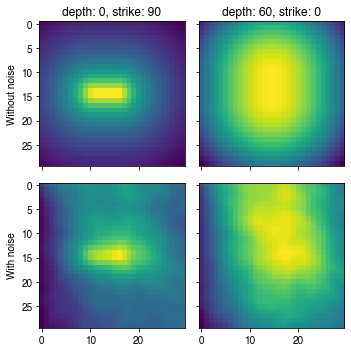

In [59]:
sim_clean = gmpe.GMPE_Simulator(add_noise=False)
sim_noisy = gmpe.GMPE_Simulator(add_noise=True)
bounds = {
    'depth': (0, 60),
    'strike': (0, 360)
}

ylabels = ['Without noise', 'With noise']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5), sharex=True, sharey=True)
for i, sim in enumerate([sim_clean, sim_noisy]):
    params, data = sim.evaluate({'depth': [0, 60], 'strike': [90, 0]})
    for j, eqdata in enumerate(data.T):
        ax = axes[i, j]
        eqparams = params[j]
        ax.imshow(eqdata.reshape(gmpe.N, gmpe.N))
        if i == 0:
            ax.set_title('depth: %s, strike: %s' % (eqparams[0], eqparams[1]))
        if j == 0:
            ax.set_ylabel(ylabels[i])
plt.tight_layout()
plt.show()

We then create a `NumericalRomBuilder` object for training a reduced
order model from the ground motion model output. This example uses three
regressors (k-nearest neighbors, decision tree, and thin plate spline radial
basis function) and three different rank values (10, 50, and 100). We start 
with 100 forward models and iterate until reaching 1000 forward models.

In [66]:
!rm -r test
rb = NumericalRomBuilder(
    'test', sim_noisy, 100, 100, 1000, 'halton', bounds, 
    ranks=[10, 50, 100],
    ml_regressors={
        'knn': KNeighborsRegressor(),
        'dt': DecisionTreeRegressor()},
    rbf_kernels=['thin_plate_spline'],
    k_val=5, vor_kval_refine=100, vor_interp_refine='thin_plate_spline')

We can then look at the reduced order models' performance for the different interpolators and ranks as a function of the number of forward models with the `error_history` attribute.

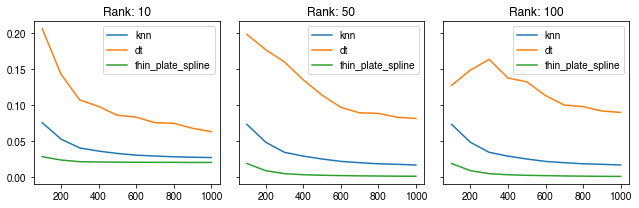

In [67]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 3), sharex=True, sharey=True)
for ax, rank in zip(axes, rb.error_history):
    for interp in rb.error_history[rank]:
        ax.plot(rb.nsamples_history, rb.error_history[rank][interp],
                label=interp)
    ax.legend()
    ax.set_title('Rank: %s' % rank)
plt.tight_layout()
plt.show()

Finally, we make some predictions with some new parameters and compare
against the true values.

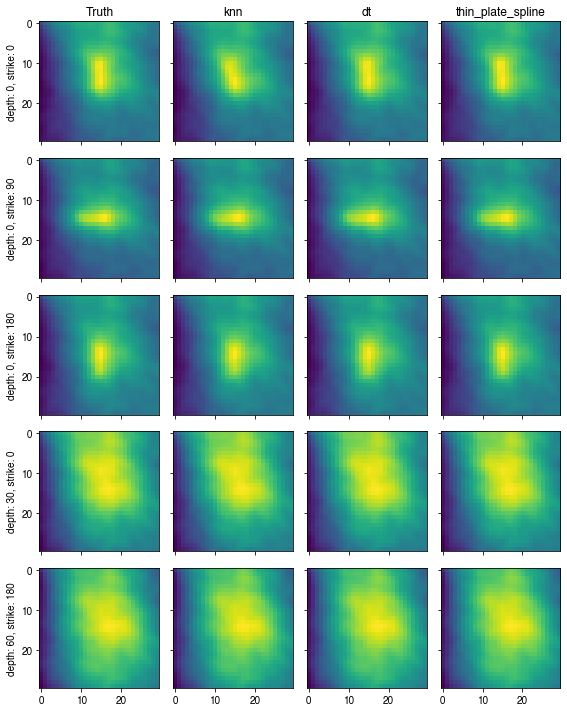

In [69]:
Ppred_dict = {
    'depth': [0, 0, 0, 30, 60],
    'strike': [0, 90, 180, 0, 180]
}
Ppred = np.array(list(Ppred_dict.values())).T
_, true = sim.evaluate(Ppred_dict)
pred = rb.rom.predict(Ppred)[100]
fig, axes = plt.subplots(nrows=Ppred.shape[0], ncols=4, sharex=True, sharey=True, figsize=(8, 10))
for j, interp in enumerate(pred):
    for i, data in enumerate(pred[interp].T):
        ax = axes[i, j+1]
        ax.imshow(data.reshape(gmpe.N, gmpe.N))
        if i == 0:
            ax.set_title(interp)
for i, data in enumerate(true.T):
    ax = axes[i, 0]
    ax.imshow(data.reshape(gmpe.N, gmpe.N))
    if i == 0:
        ax.set_title('Truth')
    ax.set_ylabel('depth: %s, strike: %s' % (Ppred[i][0], Ppred[i][1]))
plt.tight_layout()
plt.show()